# ODEs and Conservation

As we saw now in a few examples, the Runge-Kutta methods do not conserve energy.  For integrating over very long timescales, this can be problematic.

Let's explore some other methods to get a feel for what it means to be conservative.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Euler-Cromer method

The Euler-Cromer method is a first order method very similar to the first-order Euler, but with one simple change.  The update is:

$${\bf v}^{n+1} = {\bf v}^n + \tau \,{\bf a}({\bf r}^{n}) + \mathcal{O}(\tau^2)$$

$${\bf r}^{n+1} = {\bf r}^n + \tau \,{\bf v}^{n+1} + \mathcal{O}(\tau^2)$$

Notice that the only change is that we use the updated velocity, ${\bf v}^{n+1}$ in the expression to get the new position.  This is not an _implicit method_, since we already have the new velocity from the first expression.

Let's integrate our planet and compare this to the original Euler method.

We'll use the same helper module to provide the core functions we need, these are now in a module [orbit_util.py](https://github.com/zingale/computational_astrophysics/blob/main/content/ODEs/orbit_util.py).

In [2]:
import orbit_util as ou

Here's the original Euler method

In [3]:
def euler_orbit(state0, tau, T):
    """integrate an orbit given an initial position, pos0, and velocity, vel0,
    using first-order Euler integration"""
    
    times = []
    history = []
    
    # initialize time
    t = 0
    
    # store the initial conditions
    times.append(t)
    history.append(state0)
    
    # main timestep loop
    while t < T:
        
        state_old = history[-1]
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        ydot = ou.rhs(state_old)
        
        # do the Euler update
        state_new = state_old + tau * ydot
        t += tau
        
        # store the state
        times.append(t)
        history.append(state_new)
        
    return times, history

and here's Euler-Cromer

In [4]:
def euler_cromer_orbit(state0, tau, T):
    """integrate an orbit given an initial position, pos0, and velocity, vel0,
    using first-order Euler-Cromer integration"""
    
    times = []
    history = []
    
    # initialize time
    t = 0
    
    # store the initial conditions
    times.append(t)
    history.append(state0)
    
    # main timestep loop
    while t < T:
        
        state_old = history[-1]
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        ydot = ou.rhs(state_old)
        
        # do the Euler update
        unew = state_old.u + tau * ydot.u
        vnew = state_old.v + tau * ydot.v
        
        xnew = state_old.x + tau * unew
        ynew = state_old.y + tau * vnew        

        state_new = ou.OrbitState(xnew, ynew, unew, vnew)
        t += tau
        
        # store the state
        times.append(t)
        history.append(state_new)
        
    return times, history

In [5]:
state0 = ou.initial_conditions()

tau = 0.01
tmax = 1.0

times_euler, history_euler = euler_orbit(state0, tau, tmax)
times_ec, history_ec = euler_cromer_orbit(state0, tau, tmax)

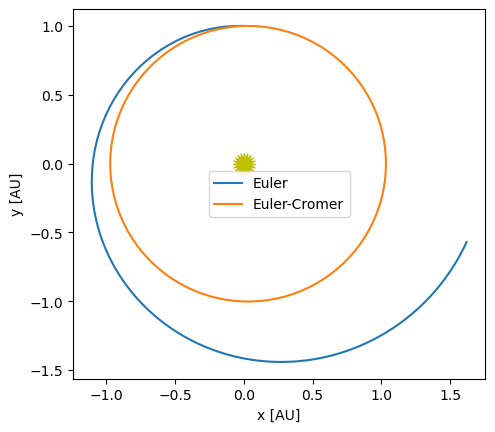

In [6]:
fig = ou.plot(history_euler, label="Euler")
ou.plot(history_ec, ax=fig.gca(), label="Euler-Cromer")
fig.gca().legend()

These are both first-order accurate, but notice how much better the Euler-Cromer solution is!

Let's consider the angular momentum of the orbit as evolved by Euler-Cromer.

Angular momentum / unit mass in the orbit plane is:

$$l = |{\bf v} \times {\bf r} | = uy - vx$$

Using the Euler-Cromer evolution:

$${\bf v}^{n+1} = {\bf v}^n + \tau {\bf a}({\bf r}^n)$$

$${\bf r}^{n+1} = {\bf r}^n + \tau {\bf v}^{n+1}$$

We can compute the new angular momentum

$$l^{n+1} = u^{n+1} y^{n+1} - v^{n+1} x^{n+1}
 = \underbrace{u^n y^n - v^n x^n}_{\mbox{this is}~ l^n} + \tau \underbrace{(a_{(x)}^n y^n - a_{(y)}^n x^n)}_{\mbox{this is}~{\bf a}\times {\bf r} = 0}$$
 
We see that, for a central potential, since ${\bf a} \times {\bf r} = 0$, the new (discrete) angular momentum is equal to the old angular momentum in this scheme.

So the Euler-Cromer method does better because it has a notion of conservation.

Note that there is still error, and it will converge globally first order.
Let's look at an eccentric orbit:

In [7]:
a = 1.0
e = 0.6

# perihelion velocity
x0 = 0.0          # start at x = 0 by definition
y0 = a * (1.0 - e)  # start at perihelion

u0 = -np.sqrt((ou.GM/a)* (1.0 + e) / (1.0 - e))
v0 = 0.0

state0 = ou.OrbitState(x0, y0, u0, v0)

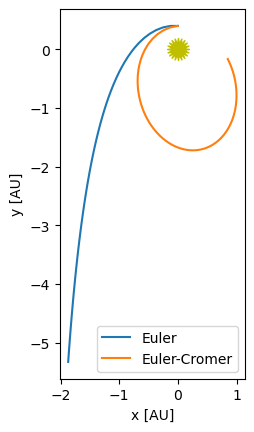

In [8]:
times_euler, history_euler = euler_orbit(state0, tau, tmax)
times_ec, history_ec = euler_cromer_orbit(state0, tau, tmax)

fig = ou.plot(history_euler, label="Euler")
ou.plot(history_ec, ax=fig.gca(), label="Euler-Cromer")
fig.gca().legend()